In [3]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip



In [4]:
BATCH_SIZE = 128

VISUAL_BACKBONES = ['RN50', 'ViT-B/32', 'ViT-B/16']

device = torch.device("cpu")


### dataset

In [5]:
transform_cifar10_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_set = torchvision.datasets.CIFAR10(root='/shareddata', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataset_name = 'CIFAR10'


Files already downloaded and verified


In [6]:
for VISUAL_BACKBONE in VISUAL_BACKBONES:
    # Load the model
    model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
    model.to(device)
    

In [7]:
prompt = 'a photo of a' # you can try different prompt

def prompt_encode(prompt, class_names):
    """
    Args:
        prompt (str): the text prefix before the class
        class_names (list): list of class names

    Returns:
        text_inputs (torch.Tensor): encoded text inputs
    """
    text = [f"{prompt} {class_name}" for class_name in class_names]

    # Encode the text using the CLIP model
    text_inputs = clip.tokenize(text).to(device)

    return text_inputs

def model_inference(model, image, text_inputs):
    
    image_features = model.encode_image(image)

    text_features = model.encode_text(text_inputs)

    logits_per_image, _ = model(image, text_inputs)

    return logits_per_image



Zero-shot performance on Fashion MNIST dataset is 55.20%, visual encoder is RN50.


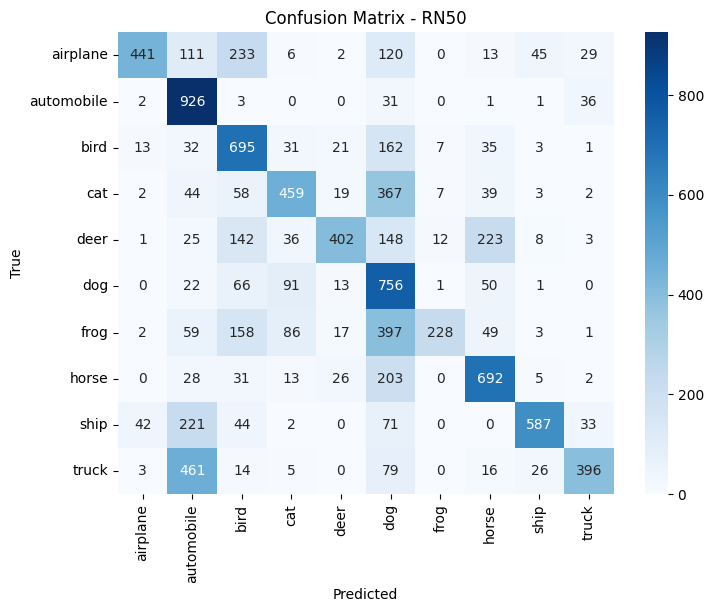

Zero-shot performance on Fashion MNIST dataset is 84.51%, visual encoder is ViT-B/32.


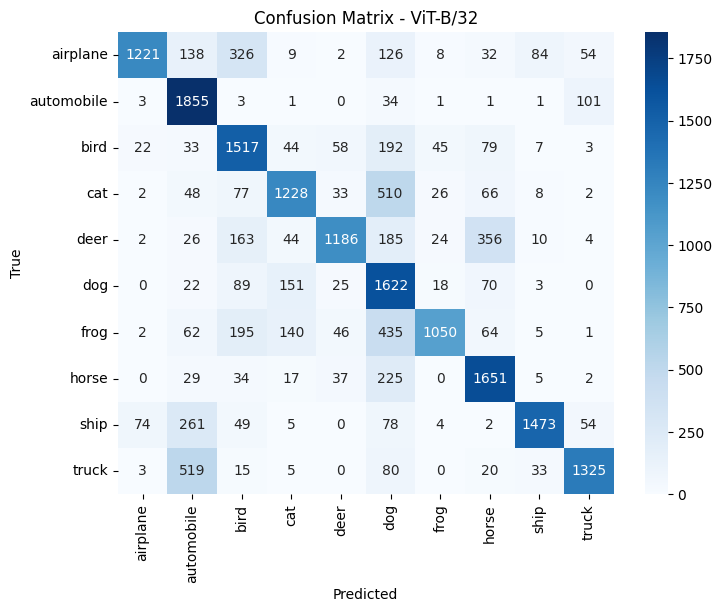

Zero-shot performance on Fashion MNIST dataset is 87.09%, visual encoder is ViT-B/16.


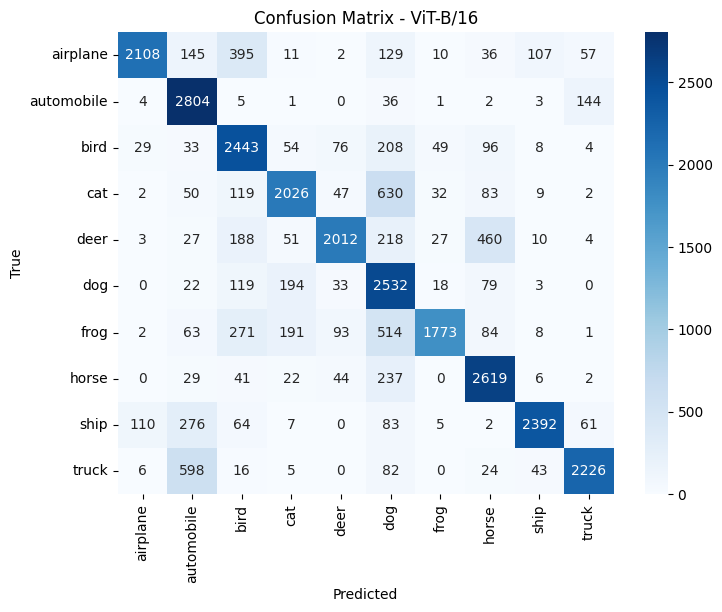

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

accuracy_list = []

all_true_labels = []
all_predicted_labels = []

# Loop through each visual backbone
for VISUAL_BACKBONE in VISUAL_BACKBONES:

    # Load the model
    model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
    model.to(device)

    testing_loss = []
    testing_acc = []

    with torch.no_grad():
        model.eval()
        for batch_idx, (images, labels) in enumerate(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Encode the text using the prompt
            text_inputs = prompt_encode(prompt, class_names)

            # Model inference
            logits = model_inference(model, images, text_inputs)

            # Calculate loss (not used in zero-shot)
            loss = F.cross_entropy(logits, labels)
            testing_loss.append(loss.item())

            # Calculate accuracy
            _, predicted = logits.max(1)
            correct = predicted.eq(labels).sum().item()
            acc = correct / BATCH_SIZE
            testing_acc.append(acc)
            
            # Append true and predicted labels to the lists
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

    # Calculate average accuracy for the current backbone
    val_acc = np.mean(testing_acc)
    accuracy_list.append(val_acc)

    print(f"Zero-shot performance on Fashion MNIST dataset is {val_acc * 100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

    # Calculate and plot confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {VISUAL_BACKBONE}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 16 * 16, 10)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 16 * 16)  
        x = self.fc1(x)
        return x

transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CIFAR10(root='./data', train=True, transform=transform_cifar10, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform_cifar10, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 训练图像模型
baseline_image_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_image_model.parameters(), lr=0.001)

# 保存每个 epoch 的测试准确度
epoch_accuracies = []

for epoch in range(5):
    baseline_image_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)  
        outputs = baseline_image_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    baseline_image_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = baseline_image_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    epoch_accuracies.append(accuracy)
    print(f'Epoch {epoch + 1}, Test Accuracy: {accuracy:.4f}')

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Test Accuracy: 0.4401
Epoch 2, Test Accuracy: 0.4816
Epoch 3, Test Accuracy: 0.5059
Epoch 4, Test Accuracy: 0.5303
Epoch 5, Test Accuracy: 0.5407


In [9]:
average_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)
print(f'Average Test Accuracy: {average_accuracy:.4f}')

Average Test Accuracy: 0.4997


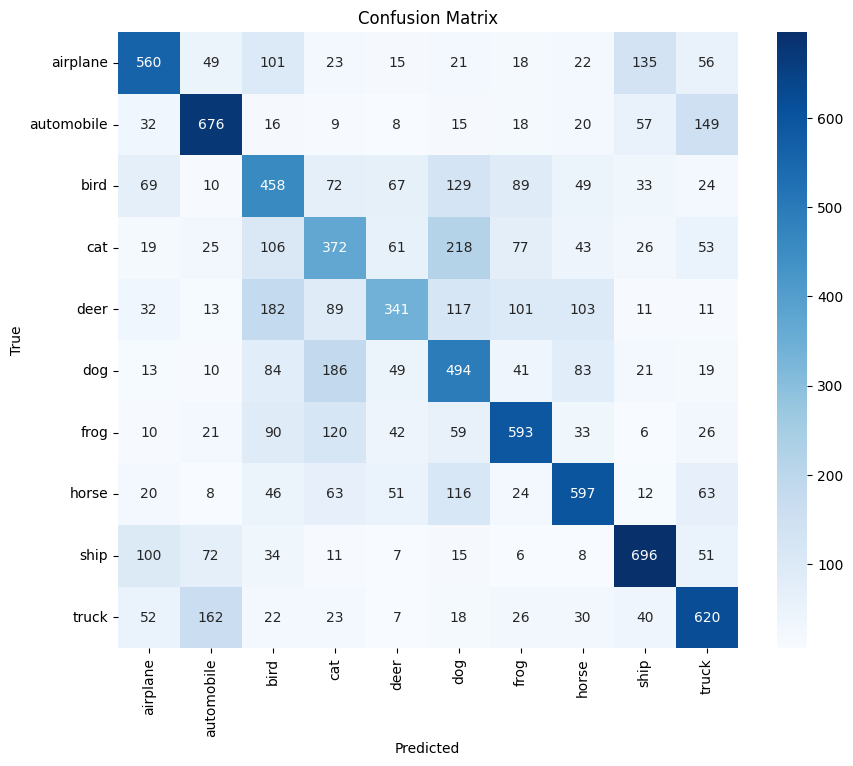

<Figure size 640x480 with 0 Axes>

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

baseline_image_model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = baseline_image_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Plot confusion matrix
class_names_cifar10 = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names_cifar10, yticklabels=class_names_cifar10)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig('Confusion Matrix-CNN.png')

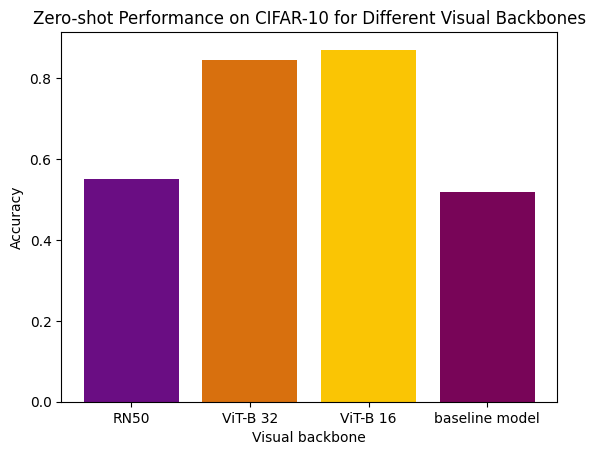

In [13]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['RN50', 'ViT-B 32', 'ViT-B 16','baseline model']
values = [0.552, 0.8451, 0.8709,0.5184]

colors = np.random.rand(len(categories), 3)

plt.bar(categories, values, color=colors)

plt.title('Zero-shot Performance on CIFAR-10 for Different Visual Backbones')
plt.xlabel('Visual backbone')
plt.ylabel('Accuracy')
plt.show()

